#  Imports

In [144]:
# Basic imports
import pandas as pd
import numpy as np
import copy
import re

# Visualization imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn imports
from sklearn.experimental import enable_halving_search_cv
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# NLTK imports
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, WordNetLemmatizer

# NLTK downloads
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')

#For Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#For XGBoost
from xgboost import XGBClassifier

# For Catboost
from catboost import CatBoostClassifier


# Preprocessing

In [145]:
df = pd.read_csv('/Users/Arsh/Flatiron/Gitlab/Capstone/Processed Tweets', index_col=[0])
df.loc[df['Democrat_Score'] == 1, 'political_group'] = 'Democratic Liberals'
df.loc[df['Democrat_Score'] == 0, 'political_group'] = 'Democratic Moderates'
df.loc[df['Republican_Score'] == 1, 'political_group'] = 'Republican Conservatives'
df.loc[df['Republican_Score'] == 0, 'political_group'] = 'Republican Moderates'
df.drop(columns = ['Date', 'Democrat_Score', 'Republican_Score', 'Username' ], inplace = True)
df.reset_index(drop = True, inplace = True)
df

,Tweet,Political_Score,political_group
0,watch live address congress underscoring impor...,1,Democratic Moderates
1,gop reversal plan destroy not obscure clear co...,1,Democratic Moderates
2,open congress pay tribute serve serve sacrific...,1,Democratic Moderates
3,yet american know attempt destroy medicare med...,1,Democratic Moderates
4,continue protect clean air clean water right l...,1,Democratic Moderates
...,...,...,...
324439,u economy need change urge biden admin work re...,0,Republican Moderates
324440,big week folk big win gotta keep go let talk,1,Democratic Moderates
324441,feed reduce demand raise interest rate unemplo...,0,Republican Moderates
324442,world leave incrementalism dust america lead w...,1,Democratic Moderates


In [153]:
X = df['Tweet']
y = df['political_group']
le = preprocessing.LabelEncoder()
cv = CountVectorizer(max_features = 100)
tfidf = TfidfVectorizer(max_features = 2500, min_df = 200)
#X = tfidf.fit_transform(X)
X1 = cv.fit_transform(X)
y = le.fit_transform(y)
#X_train, X_test, y_train, y_test = train_test_split(
           #X, y, test_size = 0.1, stratify = y, random_state = 95)
X_train1, X_test1, y_train1, y_test1 = train_test_split(
           X1, y, test_size = 0.1, stratify = y, random_state = 95)
#X_train = X_train.toarray()
#X_test = X_test.toarray()
X_train1 = X_train1.toarray()
X_test1 = X_test1.toarray()

# Modeling

## Naive Bayes

In [155]:
clf = GaussianNB()
clf.fit(X_train1, y_train1)
y_pred1 = clf.predict(X_test1)

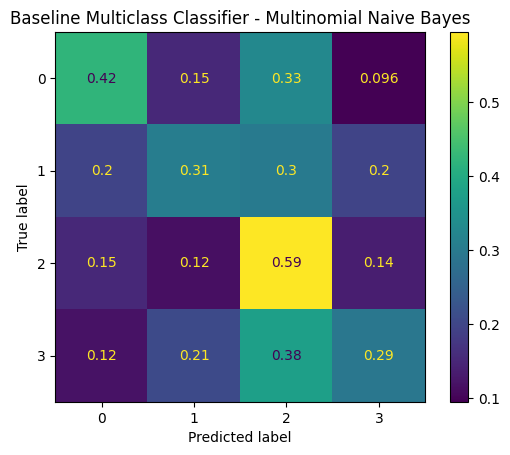

In [156]:
plot_confusion_matrix(clf, X_test1, y_test1, normalize = 'true')  
plt.title('Baseline Multiclass Classifier - Multinomial Naive Bayes')
plt.show()

In [157]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.61      0.42      0.50     11870
           1       0.30      0.31      0.30      5597
           2       0.45      0.59      0.51     10156
           3       0.28      0.29      0.29      4822

    accuracy                           0.44     32445
   macro avg       0.41      0.40      0.40     32445
weighted avg       0.46      0.44      0.44     32445



## Random Forest

In [45]:
forest_pipe = Pipeline([('model', RandomForestClassifier(n_estimators = 100, random_state = 95, n_jobs = -1, verbose = 2))])
forest_pipe.fit(X_train, y_train)
y_forest_pred = forest_pipe.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


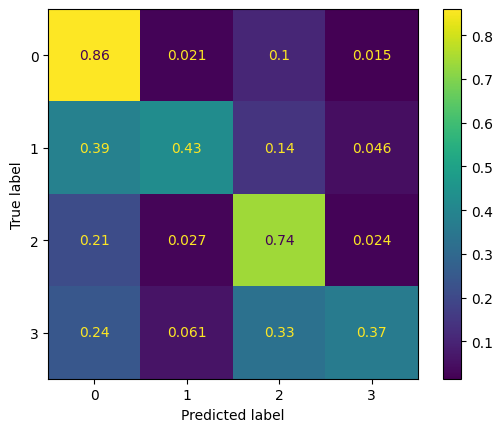

In [52]:
plot_confusion_matrix(forest_pipe, X_test, y_test, normalize = 'true')  
plt.show()
print(classification_report(y_test, y_forest_pred))

## Hypertuned Random Forest

In [86]:
forest_param_grid = {'model__n_estimators': [225, 275] , 'model__criterion' : ['gini', 'entropy'], 
                     'model__min_samples_leaf': [1], 'model__max_features': [10, 20]}

In [87]:
halving_cv = HalvingRandomSearchCV(forest_pipe, forest_param_grid, scoring="f1_weighted", n_jobs=-1, min_resources=2222, max_resources = 40000, cv = 3, factor=3, verbose = 2, random_state = 95)

In [88]:
halving_cv.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2222
max_resources_: 40000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 2222
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  25 tasks     

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 210 out of 225 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 225 

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 275 out of 275 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 275 out of 275 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 275 out of 275 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done 275 out of 275 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      |

----------
iter: 1
n_candidates: 3
n_resources: 6666
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  25 tasks     

building tree 1 of 225building tree 2 of 225

building tree 3 of 225
building tree 4 of 225
building tree 5 of 225
building tree 6 of 225
building tree 7 of 225
building tree 8 of 225
building tree 9 of 225
building tree 10 of 225
building tree 11 of 225
building tree 12 of 225
building tree 13 of 225
building tree 14 of 225
building tree 15 of 225
building tree 16 of 225
building tree 17 of 225
building tree 18 of 225
building tree 19 of 225
building tree 20 of 225
building tree 21 of 225
building tree 22 of 225
building tree 23 of 225
building tree 24 of 225
building tree 25 of 225
building tree 26 of 225
building tree 27 of 225
building tree 28 of 225
building tree 29 of 225
building tree 30 of 225
building tree 31 of 225
building tree 32 of 225
building tree 33 of 225
building tree 34 of 225


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.7s


building tree 35 of 225
building tree 36 of 225
building tree 37 of 225
building tree 38 of 225
building tree 39 of 225
building tree 40 of 225
building tree 41 of 225
building tree 42 of 225
building tree 43 of 225
building tree 44 of 225
building tree 45 of 225
building tree 46 of 225
building tree 47 of 225
building tree 48 of 225
building tree 49 of 225
building tree 50 of 225
building tree 51 of 225
building tree 52 of 225
building tree 53 of 225
building tree 54 of 225
building tree 55 of 225
building tree 56 of 225
building tree 57 of 225
building tree 58 of 225
building tree 59 of 225
building tree 60 of 225
building tree 61 of 225
building tree 62 of 225
building tree 63 of 225
building tree 64 of 225
building tree 65 of 225
building tree 66 of 225
building tree 67 of 225
building tree 68 of 225
building tree 69 of 225
building tree 70 of 225
building tree 71 of 225
building tree 72 of 225
building tree 73 of 225
building tree 74 of 225
building tree 75 of 225
building tree 76

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min


building tree 155 of 225
building tree 156 of 225
building tree 157 of 225
building tree 158 of 225
building tree 159 of 225
building tree 160 of 225
building tree 161 of 225
building tree 162 of 225
building tree 163 of 225
building tree 164 of 225
building tree 165 of 225
building tree 166 of 225
building tree 167 of 225
building tree 168 of 225
building tree 169 of 225
building tree 170 of 225
building tree 171 of 225
building tree 172 of 225
building tree 173 of 225
building tree 174 of 225
building tree 175 of 225
building tree 176 of 225
building tree 177 of 225
building tree 178 of 225
building tree 179 of 225
building tree 180 of 225
building tree 181 of 225
building tree 182 of 225
building tree 183 of 225
building tree 184 of 225
building tree 185 of 225
building tree 186 of 225
building tree 187 of 225
building tree 188 of 225
building tree 189 of 225
building tree 190 of 225
building tree 191 of 225
building tree 192 of 225
building tree 193 of 225
building tree 194 of 225


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  4.1min finished


HalvingRandomSearchCV(cv=3,
                      estimator=Pipeline(steps=[('model',
                                                 RandomForestClassifier(n_jobs=-1,
                                                                        random_state=95,
                                                                        verbose=2))]),
                      max_resources=40000, min_resources=2222, n_jobs=-1,
                      param_distributions={'model__criterion': ['gini',
                                                                'entropy'],
                                           'model__max_features': [10, 20],
                                           'model__min_samples_leaf': [1],
                                           'model__n_estimators': [225, 275]},
                      random_state=95, scoring='f1_weighted', verbose=2)

In [89]:
halving_cv.best_score_

0.5368303472082306

In [90]:
halving_cv.best_params_

{'model__n_estimators': 225,
 'model__min_samples_leaf': 1,
 'model__max_features': 10,
 'model__criterion': 'gini'}

In [91]:
optimal_model = halving_cv.best_estimator_
optimal_model

Pipeline(steps=[('model',
                 RandomForestClassifier(max_features=10, n_estimators=225,
                                        n_jobs=-1, random_state=95,
                                        verbose=2))])

In [158]:
forest_pipe_optimized = Pipeline([('model', RandomForestClassifier(
    n_estimators=225, min_samples_leaf=1, max_features=10, criterion='gini', bootstrap=False, verbose=2, n_jobs=-1, random_state=95))])
forest_pipe_optimized.fit(X_train, y_train)
y_pred = forest_pipe_optimized.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 225building tree 2 of 225
building tree 3 of 225

building tree 4 of 225
building tree 5 of 225
building tree 6 of 225
building tree 7 of 225
building tree 8 of 225
building tree 9 of 225
building tree 10 of 225
building tree 11 of 225
building tree 12 of 225
building tree 13 of 225
building tree 14 of 225
building tree 15 of 225
building tree 16 of 225
building tree 17 of 225
building tree 18 of 225
building tree 19 of 225
building tree 20 of 225
building tree 21 of 225
building tree 22 of 225
building tree 23 of 225
building tree 24 of 225


KeyboardInterrupt: 

In [128]:
categories = ['Liberal Democrats', 'Moderate Democrats', 'Conservative Republicans', 'Moderate Republicans']

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:    3.4s finished


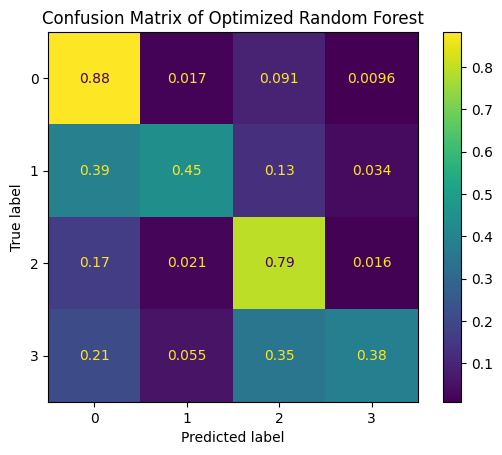

              precision    recall  f1-score   support

           0       0.68      0.88      0.77     11870
           1       0.78      0.45      0.57      5597
           2       0.70      0.79      0.74     10156
           3       0.80      0.38      0.52      4822

    accuracy                           0.71     32445
   macro avg       0.74      0.63      0.65     32445
weighted avg       0.72      0.71      0.69     32445



In [143]:
#labels = categories#  
plot_confusion_matrix(forest_pipe_optimized, X_test, y_test, normalize = 'true')  
plt.title('Confusion Matrix of Optimized Random Forest')
plt.show()
print(classification_report(y_test, y_pred))

## Catboost

In [62]:
model_CBC = CatBoostClassifier(verbose = 2)
model_CBC.fit(X_train, y_train)
y_pred = model_CBC.predict(X_test)

In [159]:
plot_confusion_matrix(model_CBC, X_test, y_test, normalize = 'true')  
plt.show()
print(classification_report(y_test, y_pred))

CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.